# Classify the images for dogs
Load libs

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import TensorBoard
import cv2
import datetime
import timeit

2024-06-30 14:41:42.086521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 14:41:42.944002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib
2024-06-30 14:41:42.944126: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-30 14:41:43.123996: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 14:41:45.368471: W tenso

# Helper function to load images

In [2]:
def load_images_from_folder(folder, image_size=(150, 150)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = Image.open(img_path)
                img = img.resize(image_size)
                img = np.array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load data

In [3]:
data_dir = '/home/prasad/09_personal/Coding_N_Work/2_ML_NN/Computer_Vision_data_Explore/Computer-Vision-Classify-Dogs/dataset_dogs/'
image_size = (150, 150)

### Load the images

In [4]:
X, y = load_images_from_folder(data_dir, image_size)

### Normalize pixel values to be between 0 and 1

In [5]:
X = X / 255.0

### Encode labels to integers

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Convert labels to one-hot encoding

In [7]:
y = to_categorical(y)

# Split data into training and validation sets

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to confirm
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (773, 150, 150, 3)
X_val shape: (194, 150, 150, 3)
y_train shape: (773, 10)
y_val shape: (194, 10)


# Define the CNN model

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# here we use a bit of bigger pooling to extract broader features
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(3, 3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(3, 3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(3, 3),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# model.summary()

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# model.summary()

2024-06-30 14:41:52.459518: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-30 14:41:52.459757: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (XDEM-laptop): /proc/driver/nvidia/version does not exist
2024-06-30 14:41:52.461447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the model

In [10]:
# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Start the training

In [11]:
%%timeit -r 1 -n 1
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 2.6330 - accuracy: 0.1746

2024-06-30 14:46:13.947589: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4545576960 exceeds 10% of free system memory.


25/25 [==============================] - 46s 2s/step - loss: 2.6330 - accuracy: 0.1746 - val_loss: 2.1042 - val_accuracy: 0.3196
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.4935 - accuracy: 0.5149

2024-06-30 14:46:53.882113: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4545576960 exceeds 10% of free system memory.


25/25 [==============================] - 39s 2s/step - loss: 1.4935 - accuracy: 0.5149 - val_loss: 0.9356 - val_accuracy: 0.7371
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.8771

2024-06-30 14:47:37.568063: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4545576960 exceeds 10% of free system memory.


25/25 [==============================] - 44s 2s/step - loss: 0.4697 - accuracy: 0.8771 - val_loss: 0.2424 - val_accuracy: 0.9433
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9715

2024-06-30 14:48:12.282601: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4545576960 exceeds 10% of free system memory.


25/25 [==============================] - 34s 1s/step - loss: 0.1168 - accuracy: 0.9715 - val_loss: 0.0873 - val_accuracy: 0.9691
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9909

2024-06-30 14:48:45.412810: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4545576960 exceeds 10% of free system memory.


25/25 [==============================] - 33s 1s/step - loss: 0.0517 - accuracy: 0.9909 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 6/50
25/25 [==============================] - 34s 1s/step - loss: 0.0166 - accuracy: 0.9961 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 7/50
25/25 [==============================] - 31s 1s/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 8/50
25/25 [==============================] - 33s 1s/step - loss: 0.0195 - accuracy: 0.9987 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 9/50
25/25 [==============================] - 34s 1s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 4.2924e-05 - val_accuracy: 1.0000
Epoch 10/50
25/25 [==============================] - 33s 1s/step - loss: 8.5847e-04 - accuracy: 1.0000 - val_loss: 1.7578e-05 - val_accuracy: 1.0000
Epoch 11/50
25/25 [==============================] - 35s 1s/step - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 12/50
25/25

## Plot Losses

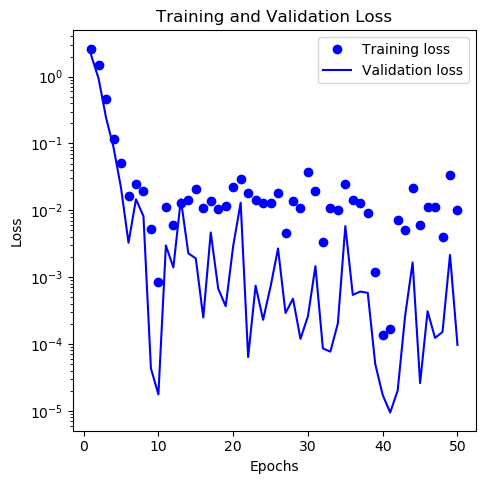

In [12]:
# Get training and validation loss from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(5.2, 5.2))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.yscale('log') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG file
plt.savefig('training_validation_loss_50epochs.png')

# Show plot
plt.show()

Start tesnorboard

In [ ]:
%tensorboard --logdir logs/fit

## Evaluate the model on the validation set

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Save the model
model.save('dog_breed_classifier_model.h5')

# Predict breed of a random dog from the dataset

In [ ]:
def predict_random_image(model, X, y, label_encoder, save_dir):
    # Pick a random image from our dataset
    idx = random.randint(0, len(X) - 1)
    
    # Predict the class of the selected image
    y_pred = model.predict(X[idx].reshape(1, 150, 150, 3))
    print(f'Prediction probabilities: {y_pred}')
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])
    
    img = Image.fromarray((X[idx] * 255).astype(np.uint8))
    # Resize the image to the desired output size
    output_size = (500,500)
    img = img.resize(output_size, Image.ANTIALIAS)
    
    plt.imshow(X[idx])
    plt.title(f'Actual: {label_encoder.inverse_transform([np.argmax(y[idx])])[0]}')
    plt.show()
    
    # Draw the predicted class on the image
    draw = ImageDraw.Draw(img)
    font_size = 30
    font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
    font = ImageFont.truetype(font_path, font_size)
    text = f'Predicted: {predicted_class[0]}'
    textwidth, textheight = draw.textsize(text, font)
    width, height = img.size
    margin = 10
    x = width - textwidth - margin
    y = height - textheight - margin

    draw.text((x, y), text, font=font, fill=(255, 255, 255, 255))
    
    save_path = os.path.join(save_dir, f'predicted_{idx}_Orig.png')
    img.save(save_path)

    # Get the predicted class
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])
    print(f'Predicted class: {predicted_class[0]}')

# Load the trained model
model = load_model('dog_breed_classifier_model.h5')

pred_dir = '/home/prasad/09_personal/Coding_N_Work/2_ML_NN/Computer_Vision_data_Explore/Computer-Vision-Classify-Dogs/zzz_my_predictions/'

# Predict for a random image
predict_random_image(model, X_val, y_val, label_encoder, pred_dir)

## Plot Losses

In [ ]:
# Get training and validation loss from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(5.2, 5.2))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.yscale('log') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG file
plt.savefig('training_validation_loss.png')

# Show plot
plt.show()

## Here I test actual pictures of my dog and see if my model identifies it
She is labrador btw ;)

In [ ]:
test_dir = '/home/prasad/09_personal/Coding_N_Work/2_ML_NN/Computer_Vision_data_Explore/Computer-Vision-Classify-Dogs/Test/'

# Check the input shape of the model
input_shape = model.layers[0].input_shape
img_height, img_width = input_shape[1], input_shape[2]
target_image_size=(img_height, img_width)

# Iterate through the images in the test directory and process them
test_images = []
for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)
    img = Image.open(img_path)
    img = img.resize(target_image_size)
    img = np.array(img)
    img = img / 255.0 # Normalize the image array
    test_images.append(img)

len(test_images)

## Make predictions for my dog 

In [ ]:
def predict_my_test_image(model, X, label_encoder, idx, save_dir, training_images):
    os.makedirs(save_dir, exist_ok=True)

    # Predict the class of the selected image
    y_pred = model.predict(X[idx].reshape(1, 150, 150, 3))
    # print(f'Prediction probabilities: {y_pred}')

    # Get the predicted class
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])
    print(f'Predicted class: {predicted_class[0]}')

    # idx = random.randint(0, len(X) - 1)
    # plt.imshow(X[idx])
    # plt.show()

    # Convert numpy array to PIL image
    img = Image.fromarray((X[idx] * 255).astype(np.uint8))
    # Resize the image to the desired output size
    output_size = (500,500)
    img = img.resize(output_size, Image.ANTIALIAS)

    # Draw the predicted class on the image
    draw = ImageDraw.Draw(img)
    font_size = 30
    font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
    font = ImageFont.truetype(font_path, font_size)
    text = f'Predicted: {predicted_class[0]}'
    textwidth, textheight = draw.textsize(text, font)
    width, height = img.size
    margin = 10
    x = width - textwidth - margin
    y = height - textheight - margin

    draw.text((x, y), text, font=font, fill=(255, 255, 255, 255))

    # # Find the best matching image from training dataset X
    # best_match_idx = np.argmax(y_pred)
    # best_match_img = Image.fromarray((training_images[best_match_idx] * 255).astype(np.uint8))
    # best_match_img = best_match_img.resize(output_size, Image.ANTIALIAS)

    # # Create a new image with the original and the best match side by side
    # comparison_img = Image.new('RGB', (2 * output_size[0], output_size[1]))
    # comparison_img.paste(img, (0, 0))
    # comparison_img.paste(best_match_img, (output_size[0], 0))

    # # Save the comparison image with prediction text
    # save_path = os.path.join(save_dir, f'comparison_{idx}.png')
    # comparison_img.save(save_path)
    # print(f'Saved comparison image with prediction at {save_path}')

    # Save the image with prediction text
    save_path = os.path.join(save_dir, f'predicted_{idx}_myDog.png')
    img.save(save_path)
    print(f'Saved image with prediction at {save_path}')

# Load the trained model
model = load_model('dog_breed_classifier_model.h5')

# Predict for a random image
for img_id in range(len(test_images)):
    predict_my_test_image(model, test_images, label_encoder, img_id, pred_dir, X)

## Plot Losses

In [ ]:
# Get training and validation loss from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.yscale('log') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG file
plt.savefig('training_validation_loss.png')

# Show plot
plt.show()